In [1]:
# BME 808 Project
# Protein fold classification using SVM
# Andrew Mullen & Otylia Nowicka

import numpy as np
from sklearn import svm
!pip install Bio
from Bio import SeqIO
from sklearn import metrics

# Read In Data

In [2]:
# Read sequence data
seqFile = 'sequences.txt'

sequenceDict = dict()

fasta_sequences = SeqIO.parse(open(seqFile),'fasta')

for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        sequenceDict[name] = sequence.upper()

In [3]:
# Read Label Data
file = open('scop-cla-latest.txt')
lines = file.read()
lines = lines.split('\n')
labels = dict()
for i in range(6,len(lines)-1) :
    temp = lines[i].split()
    key = temp[0]
    temp = temp[10]
    value = int(temp[temp.find('CL=100000')+9])
    labels[key] = value

# Feature Extraction

In [4]:
def featureExtraction(seq) :
    #Declare output varaible
    output = np.zeros((49))
    
    #Amino Acid Frequency
    output[0] = seq.count('A')#Alanine
    output[1] = seq.count('B')#Asparagine
    output[2] = seq.count('C')#Cysteine
    output[3] = seq.count('D')#Aspartic Acid
    output[4] = seq.count('E')#Glutamic Acid
    output[5] = seq.count('F')#Phenylalanine
    output[6] = seq.count('G')#Glycine
    output[7] = seq.count('H')#Histidine
    output[8] = seq.count('I')#Isoleucine
    output[9] = seq.count('K')#Lysine
    output[10] = seq.count('L')#Leucine
    output[11] = seq.count('M')#Methionine
    output[12] = seq.count('N')#Asparginine
    output[13] = seq.count('O')#Pyrrolysine
    output[14] = seq.count('P')#Proline
    output[15] = seq.count('Q')#Glutamine
    output[16] = seq.count('R')#Arginine
    output[17] = seq.count('S')#Serine
    output[18] = seq.count('T')#Threonine
    output[19] = seq.count('U')#Selenocysteine
    output[20] = seq.count('V')#Valine
    output[21] = seq.count('W')#Tryptophan
    output[22] = seq.count('X')#Any amino acid
    output[23] = seq.count('Y')#Tyrosine
    output[24] = seq.count('Z')#Glutamic Acid or Glutamine
    
    #Physiochemical Property Grouping - 3 groups each
        #From https://www.hindawi.com/journals/bmri/2016/6802832/
        
    #Hydrophobicity
    output[25] = sum(output[[3,4,9,12,15,16]])#Group1
    output[26] = sum(output[[0,6,7,14,17,18,23]])#Group2
    output[27] = sum(output[[2,5,8,10,11,20,21]])#Group3
    
    #Van der Waals Volume
    output[28] = sum(output[[0,2,3,6,14,17,18]])#Group1
    output[29] = sum(output[[4,8,10,12,15,20]])#Group2
    output[30] = sum(output[[5,7,9,11,16,21,23]])#Group3
    
    #Polarity
    output[31] = sum(output[[2,5,8,10,11,20,21]])#Group1
    output[32] = sum(output[[0,6,14,17,18]])#Group2
    output[33] = sum(output[[5,7,9,11,16,21,23]])#Group3
    
    #Polarizability
    output[34] = sum(output[[0,3,6,17,18]])#Group1
    output[35] = sum(output[[2,4,8,10,12,14,15,20]])#Group2
    output[36] = sum(output[[5,7,9,11,16,21,23]])#Group3
    
    #Charge
    output[37] = sum(output[[9,16]])#Group1
    output[38] = sum(output[[0,2,5,6,7,8,10,11,12,14,15,17,18,20,21,23]])#Group2
    output[39] = sum(output[[3,4]])#Group3
    
    #Surface Tension
    output[40] = sum(output[[0,3,6,7,12,15,16]])#Group1
    output[41] = sum(output[[2,4,9,17,18]])#Group2
    output[42] = sum(output[[5,8,10,11,14,20,21,23]])#Group3
    
    #Secondary Structure
    output[43] = sum(output[[0,4,7,9,10,11,15,16]])#Group1
    output[44] = sum(output[[2,5,8,18,29,21,23]])#Group2
    output[45] = sum(output[[3,6,12,14,17]])#Group3
    
    #Solvent Accesibility
    output[46] = sum(output[[0,2,5,6,8,10,20,21]])#Group1
    output[47] = sum(output[[3,4,9,12,15,16]])#Group2
    output[48] = sum(output[[7,11,14,17,18,23]])#Group3
    
    
    return output/len(seq)



In [5]:
#Initialize Feature Array
featureArray = np.zeros((len(sequenceDict), 50))
#Initialize Counter
count = 0


for key, value in sequenceDict.items() :
    #Extract Features
    features = featureExtraction(value)
    #Place in array
    featureArray[count,0:len(features)] = features
    #Assign Label to last value
    featureArray[count,len(features)] = labels[key]
    count += 1
    
# Save Feature Array
np.save('features.npy', featureArray)

# SVM Model Training

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
#Load in data
data = np.load('features.npy')
xTrain = data[0:26820,0:49]
yTrain = data[0:26820,49]
xTest = data[26820:33525,0:49]
yTest = data[26820:33525,49]


#Model
model = svm.SVC(kernel='linear')#poly', degree=5, verbose=2)
model.fit(xTrain, yTrain)

#Model Score
print('Score:', model.score(xTest, yTest))

#Make Predictions
yPred = model.predict(xTest)

#Print the confusion matrix
print(metrics.confusion_matrix(yTest, yPred))

Score: 0.5158836689038031
[[801  28 273 264  16]
 [ 57 838 225 297  10]
 [134 138 874 396   0]
 [306 405 539 747  42]
 [ 41  34   6  35 199]]


In [7]:
import pickle
modelPath = 'SVM_Model.pkl'
# Save model
pickle.dump(model, open(modelPath, 'wb'))

Predicted  0.0  1.0   2.0  3.0  4.0
Actual                             
0.0        908   33   205  216   20
1.0         58  855   223  280   11
2.0         80  111  1088  263    0
3.0        235  368   630  758   48
4.0         42   21     3   31  218

Predicted   0.0   1.0   2.0   3.0  4.0   All
Actual                                      
0.0         908    33   205   216   20  1382
1.0          58   855   223   280   11  1427
2.0          80   111  1088   263    0  1542
3.0         235   368   630   758   48  2039
4.0          42    21     3    31  218   315
All        1323  1388  2149  1548  297  6705

Predicted       0.0       1.0       2.0       3.0       4.0
Actual                                                     
0.0        0.657019  0.023125  0.132944  0.105934  0.063492
1.0        0.041968  0.599159  0.144617  0.137322  0.034921
2.0        0.057887  0.077786  0.705577  0.128985  0.000000
3.0        0.170043  0.257884  0.408560  0.371751  0.152381
4.0        0.030391  0.014

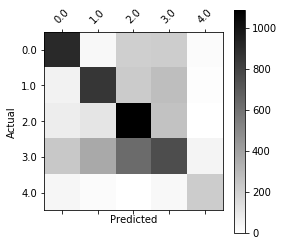

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
act_y = pd.Series(yTest, name = 'Actual')
pred_y = pd.Series(yPred, name = 'Predicted')
df_conf = pd.crosstab(act_y, pred_y)
print(df_conf)
print()
df_conf1 = pd.crosstab(act_y, pred_y, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(df_conf1)
print()
# if you need to normalize it
df_conf_norm = df_conf / df_conf.sum(axis=1)
print(df_conf_norm)
print()

# now for plotting
def plot_confusion_matrix(df_conf, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_conf, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(df_conf.columns))
    plt.xticks(tick_marks, df_conf.columns, rotation=45)
    plt.yticks(tick_marks, df_conf.index)
    
    #plt.tight_layout()
    plt.ylabel(df_conf.index.name)
    plt.xlabel(df_conf.columns.name)

plot_confusion_matrix(df_conf)

print()
print(metrics.classification_report(yTest, yPred, digits=3))

# Trouble Shooting

In [9]:
AACount = dict()
for key, value in sequenceDict.items() :
    for letter in value :
        if letter in AACount.keys() :
            AACount[letter] += 1
        else :
            AACount[letter] = 1

In [10]:
np.shape(featureArray)

(33525, 50)

In [18]:
np.max(model.coef_)

11.331677741532985